### Import modules

In [1]:
# Parameters
import parameters as p

# Data manipulation
import numpy as np
import pandas as pd

# Modeling
from sklearn import datasets
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import feature_selection

# R interface
from rpy2.robjects import StrVector
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Inline plotting
%matplotlib inline

/Users/jmcontreras/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Define functions

In [2]:
def make_synth_data(p):
    '''Create a synthetic dataset of variable size using sample generators from scikit-learn.
    The number of informative features and the target variable type (discrete or continuous) are
    also declareable parameters.
    '''
    if p.DISCRETE_Y:
        X, y = datasets.make_classification(n_samples=p.N_SAMPLES, n_features=p.N_FEATURES,
                                            n_informative=p.N_INFORMATIVE, n_redundant=0,
                                            n_repeated=0, n_classes=p.N_CLASSES,
                                            n_clusters_per_class=1, weights=p.WEIGHTS,
                                            flip_y=0.01, class_sep=1.0, hypercube=False,
                                            shift=0.0, scale=1.0, shuffle=True,
                                            random_state=None)
    else:
        X, y = datasets.make_regression(n_samples=p.N_SAMPLES, n_features=p.N_FEATURES,
                                        n_informative=p.N_INFORMATIVE, n_targets=1, bias=0.0,
                                        effective_rank=None, tail_strength=0.5, noise=0.0,
                                        shuffle=True, coef=False, random_state=None)
    
    # Transform X from NumPy array to pandas DataFrame
    X = pd.DataFrame(X, columns=['f{}'.format(i) for i in range(p.N_FEATURES)])
    
    return X, y

def select_block_vars(X_train, y_train, p):
    '''Use feature selection on the training data to select the blocking variables.'''
    # Create feature selector
    sel = feature_selection.SelectKBest(score_func=feature_selection.f_classif)
    
    # Perform feature selection
    sel.fit(X_train, y_train)
    
    # Extract blocking variables
    return [a for (a, b) in sorted(zip(sel.scores_, X.columns))][-p.N_INFORMATIVE:]

def assign_folds(X, block_vars, p):
    '''Assign each unit in a dataset to a cross-validation fold using blockTools. The number of
    folds as well as blockTools parameters are declarable.
    '''
    # Activate pandas conversion support
    pandas2ri.activate()
    # Import blockTools
    blockTools = importr('blockTools')

    # Assign units to blocks and then folds
    blocks = blockTools.block(X.reset_index(), id_vars='index',
                              block_vars=StrVector(block_vars), n_tr=p.K)
    folds = blockTools.assignment(blocks)
    # Transform folds to DataFrame
    folds = pandas2ri.ri2py_dataframe(folds.rx2('assg').rx2('1')).astype(int)

    # Reformat DataFrame for cross-validation
    max_dist = folds.pop('Max Distance')
    folds.columns = np.arange(p.K)
    folds = folds.stack()
    folds.index = folds.index.droplevel(0)
    folds = folds.reset_index()
    folds.columns = ['k', 'unit']
    
    # Shuffle cross-validation assignment as control
    folds['unit_shuffled'] = folds['unit'].sample(frac=1).reset_index(drop=True)

    return folds, max_dist

def evaluate_model(model, X, y, folds, col, p):
    '''Perform k-folds cross-validation using the column COL in FOLDS.'''
    # Create DataFrame to hold results
    df = pd.DataFrame(None, columns=['col', 'k', 'accuracy'])

    # Iterate through folds
    for k in range(p.K):
        # Identify units in testing set
        is_test = np.in1d(np.arange(y.shape[0]), folds.ix[folds['k'] == k, col])
        # Fit model on other units
        model.fit(X.ix[~is_test, :], y[~is_test])
        # Evaluate model accuracy on testing set
        accuracy = model.score(X.ix[is_test, :], y[is_test])
        df = df.append({'col': col, 'k': k, 'accuracy': accuracy}, ignore_index=True)
    
    # Return filled DataFrame
    return df

def visualize_results(data1, data2, x, y, x_lab, y_lab, x_tic):
    '''Draw a violin plot to visualize the comparison between two value distributions.'''
    # Create violin plot
    sns.violinplot(x=x, y=y, data=data1.append(data2), order=['unit', 'unit_shuffled'])
    # Add title
    plt.title('{} by {}'.format(x_lab, y_lab), size=18, y=1.05)
    # Label x-ticks
    plt.xticks(range(len(x_tic)), x_tic, size=12)
    # Add axis labels
    plt.ylabel(y_lab, size=15)
    plt.xlabel(x_lab, size=15);

### Create synthetic data

In [3]:
X, y = make_synth_data(p)

### Split data into training and testing sets

In [4]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=0.33,
                                                                     random_state=None)

### Select blocking variables

In [ ]:
block_vars = select_block_vars(X_train, y_train, p)

### Use blocks to assign folds

In [6]:
# Use blockTools for cross-validation assignment
folds, max_dist = assign_folds(X_test, block_vars, p)

### Fit and evaluate model

In [8]:
# Create model object
clf = linear_model.LogisticRegression(penalty='l2', C=1.0, random_state=None)

# Fit model and evaluate performance
treat = evaluate_model(clf, X_test, y_test, folds, 'unit', p)
control = evaluate_model(clf, X_test, y_test, folds, 'unit_shuffled', p)

### Store results

In [ ]:
df = pd.DataFrame(None, columns=['n_sim', 'condition', 'accuracy'])

# Iterate through folds
for k in range(p.K):
    # Identify units in testing set
    is_test = np.in1d(np.arange(y.shape[0]), folds.ix[folds['k'] == k, col])
    # Fit model on other units
    model.fit(X.ix[~is_test, :], y[~is_test])
    # Evaluate model accuracy on testing set
    accuracy = model.score(X.ix[is_test, :], y[is_test])
    df = df.append({'col': col, 'k': k, 'accuracy': accuracy}, ignore_index=True)

### Create visualization

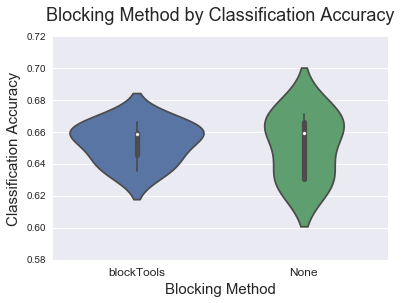

In [9]:
visualize_results(treat, control, 'col', 'accuracy',
                  'Blocking Method', 'Classification Accuracy',
                  ['blockTools', 'None'])